# Navigation



### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Import Library


In [4]:
import random
from collections import deque,namedtuple
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


### 3. Neural Network 
- The model consists of two hidden layers with 128 units and 32 units consecutively. nn.Linear() is the linear function that take m inputs and give n outputs. Ax=b is an example of linear equation for this.
- The input consitsts of 37 features and gives the output of 4.
- ReLu is an activation function that is used on the first and second hidden layer. Basically, the function apply  max(0, x) element wise. In my opinion, ReLu is one of the most used activation function.


In [5]:
class QNetwork(nn.Module):
 def __init__(self,state_size,action_size,seed,fc1=128,fc2=32):
  super(QNetwork,self).__init__()
  self.seed=torch.manual_seed(seed)
  self.fc1=nn.Linear(state_size,fc1)
  self.fc2=nn.Linear(fc1,fc2)
  self.fc3=nn.Linear(fc2,action_size)

 def forward(self,state):
  x=F.relu(self.fc1(state))
  x=F.relu(self.fc2(x))
  return self.fc3(x)

### 4. Agent  (Q Learning)

- Here I have seperated the steps for update Q Learning and Target model. I have tried different numbers but the results are not     signifiantly different.



The hyperparameters are listed as follow:

- buffer size (The maximum number of experiences in the replay buffer) : 1e5
- batchsize (Numbers of experiences that is sampled from replay buffer during learning) : 64
- gamma (Discount Rate that is used to compue the Q target) : 0.99
- lr (Learning rate for gradient descent) : 5e-4
- q_Learning_step (Number of steps before updating the weights to minimize loss) : 4
- update_targetevery (Number of steps before updating the weight of Q target model: 4
- tau (Discount rate for updating target model to match with the parameter of local model): 1e-3                            

*During experiment i have tried to change tau based on number of episodes but there is no significant improvement in terms of number of episodes used to solve the environment.

In [6]:


buffer_size=int(1e5)
batch_size=64
gamma=0.99
lr=5e-4
qlearn_step=4
update_targetevery=4


device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
 def __init__(self,state_size,action_size,seed):
  self.state_size=state_size
  self.action_size=action_size
  self.seed=random.seed(seed)

  #Q-Network
  self.qnetwork_local=QNetwork(state_size,action_size,seed).to(device)
  self.qnetwork_target=QNetwork(state_size,action_size,seed).to(device)
  self.optimizer=optim.Adam(self.qnetwork_local.parameters(),lr=lr)
  
  #Replay Memory
  self.memory=ReplayBuffer(action_size,buffer_size,batch_size,seed)
  self.t_step=0
  self.qlearn=0

 def step(self,state,action,reward,next_state,done,i_episode):
  self.memory.add(state,action,reward,next_state,done)
  self.qlearn=(self.qlearn+1)%qlearn_step
  self.t_step=(self.t_step+1)%update_targetevery
  
  if i_episode<200:
   tau=1e-3
  else:
   tau=1e-3
    
  if len(self.memory)>batch_size:
   if self.qlearn==0:
     experiences=self.memory.sample()
     self.learn(experiences,gamma)
   if self.t_step==0:
     self.target_updates(self.qnetwork_local,self.qnetwork_target,tau)
        
 def act(self,state,eps=0):
  state=torch.from_numpy(state).float().unsqueeze(0).to(device)
  self.qnetwork_local.eval()
  with torch.no_grad():
   action_values=self.qnetwork_local(state)
  self.qnetwork_local.train()
  
  if random.random()>eps:
   return np.argmax(action_values.cpu().data.numpy())
  else:
   return random.choice(np.arange(self.action_size))

 def learn(self,experiences,gamma):
  states,actions,rewards,next_states,dones=experiences
  Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1) 
  Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
  Q_expected = self.qnetwork_local(states).gather(1, actions)
  


  #Compute Loss
  loss=F.mse_loss(Q_expected,Q_targets)
  self.optimizer.zero_grad()
  loss.backward()
  self.optimizer.step()
  
 
 def target_updates(self,local_model,target_model,tau):
  for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
   target_param.data.copy_(tau*local_param.data+(1.0-tau)*target_param.data)

### 5. Replay Buffer


In [8]:
class ReplayBuffer:
 def __init__(self,action_size,buffer_size,batch_size,seed):
  self.action_size=action_size
  self.memory=deque(maxlen=buffer_size)
  self.batch_size=batch_size
  self.experience=namedtuple("Experience",field_names=["state","action","reward","next_state","done"])
  self.seed=random.seed(seed)
 
 def add(self,state,action,reward,next_state,done):
  e=self.experience(state,action,reward,next_state,done)
  self.memory.append(e)

 def sample(self):
  experiences=random.sample(self.memory,k=self.batch_size)
  states=torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
  actions=torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
  rewards=torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
  next_states=torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
  dones=torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  return (states,actions,rewards,next_states,dones)
 
 def __len__(self):
  return len(self.memory)

### 5. Training

In [10]:
agent=Agent(state_size=37,action_size=4,seed=0)



def dqn(n_episodes=1000,max_t=1000,eps_start=1,eps_end=0.01,eps_decay=0.97):
 scores=[]
 score_window=deque(maxlen=100)
 eps=eps_start

 for i_episode in range(1,n_episodes+1):
  env_info = env.reset(train_mode=True)[brain_name]
  state = env_info.vector_observations[0]
  #state=env.reset()
  score=0

  for t in range(max_t):
   action=agent.act(state,eps)
   env_info = env.step(action)[brain_name] 

   next_state = env_info.vector_observations[0]   
   reward = env_info.rewards[0]                   
   done = env_info.local_done[0]
   agent.step(state,action,reward,next_state,done,i_episode)
   score += reward                                
   state = next_state                             
   if done:                                       
    break
  score_window.append(score)
  scores.append(score)
  eps=max(eps_end,eps_decay*eps)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)), end="")
  if i_episode % 100 == 0:
   print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
  if np.mean(score_window)>=13.0:
   print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
   torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
   break
 return scores

scores = dqn()

Episode 100	Average Score: 4.21
Episode 200	Average Score: 11.33
Episode 239	Average Score: 13.03
Environment solved in 239 episodes!	Average Score: 13.03


### 6. Plot reward

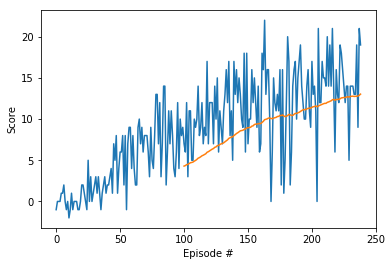

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(100,len(scores)),pd.Series(scores).rolling(100).mean()[100:])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Future work

- Double Q Learning
- Prioritized Experienced Replay